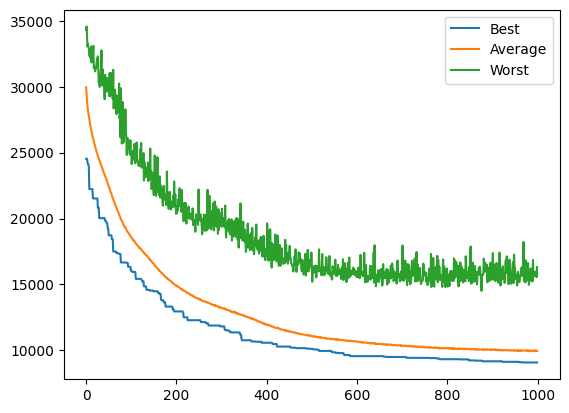

9071.0
[[51, 12, 25, 46, 48, 24, 5, 15, 37, 38, 40, 39, 34, 35, 36, 44, 49, 16, 50, 20, 23, 30, 21, 31, 18, 22, 1, 32, 19, 41, 8, 9, 10, 43, 33, 4, 6, 45, 3, 17, 42, 7, 2, 29, 47, 26, 28, 27, 13, 14, 52, 11]]


In [7]:
from GA import GA
from TSP import TSPChromosome
from SPP import SPPChromosome
import utils

def sum_of_costs(graph, path):
    if len(set(path)) != len(path):
        return float('inf')
    
    s = 0
    mat = graph['matrix']
    for i in range(len(path)-1):
        s += mat[path[i]-1][path[i+1]-1]
    return s

def sum_of_costs_cyclic(graph, path):
    if len(set(path)) != len(path):
        return float('inf')
    
    s = 0
    mat = graph['matrix']
    for i in range(len(path)-1):
        s += mat[path[i]-1][path[i+1]-1]
    return s + mat[path[0]-1][path[-1]-1]

def solve_tsp(graph, show=False, fn=sum_of_costs_cyclic, chromosome=TSPChromosome, pop_size=100, no_of_gen=1000, inf_val=700):
    gaParam = {
        "popSize": pop_size,
        "noGen": no_of_gen,
    }

    problParam = {
        "graph": graph,
        "function": fn
    }

    best_fitnesses = []
    worst_fitnesses = []
    avg_fitnesses = []

    ga = GA(chromosome, gaParam, problParam)
    ga.initialisation()
    ga.evaluation()

    for _ in range(no_of_gen):
        all_fitnesses = [c.fitness for c in ga.population]

        best_fitnesses.append(ga.bestChromosome().fitness)
        worst_fitnesses.append(ga.worstChromosome().fitness)
        avg_fitnesses.append(sum(all_fitnesses) / len(all_fitnesses))

        ga.oneGenerationElitism2()

    if show:
        utils.plot_stats([i for i in range(len(best_fitnesses))], best_fitnesses, avg_fitnesses, worst_fitnesses)

    best = min(ga.population, key=lambda x: x.fitness)
    solution = [best]
    for x in ga.population:
        if x.fitness == best.fitness and x not in solution:
            solution.append(x)

    return solution, (best_fitnesses, avg_fitnesses, worst_fitnesses)


graph = utils.read_tsp('berlin52.tsp')
c, data = solve_tsp(graph, True, sum_of_costs_cyclic, TSPChromosome, 2000, 1000)
print(c[0].fitness)
print([x.repres for x in c])

In [5]:
import os

def solve(filename):
    graph = utils.read_graph(filename)
    filen, extension = os.path.splitext(filename)
    out_filename = filen + '_sol' + extension

    with open(out_filename, 'w') as f:
        f.write(f"{graph['noNodes']}\n")
        s = solve_tsp(graph, False, sum_of_costs_cyclic, TSPChromosome)[0]
        f.write(','.join([str(x) for x in s.repres]) + '\n')
        f.write(f"{s.fitness}\n")

        s = solve_tsp(graph, False, sum_of_costs, SPPChromosome)[0]
        f.write(f'{len(s.repres)}\n')
        f.write(','.join([str(x) for x in s.repres]) + '\n')
        f.write(f"{s.fitness}\n")

def solve_many():
    solve('TSP/easy_01_tsp.txt')
    solve('TSP/easy_02.txt')
    solve('TSP/easy_03.txt')
    solve('TSP/medium_01.txt')
    solve('TSP/medium_02.txt')
    solve('TSP/hard_01.txt')
    solve('TSP/hard_02.txt')

# solve_many()

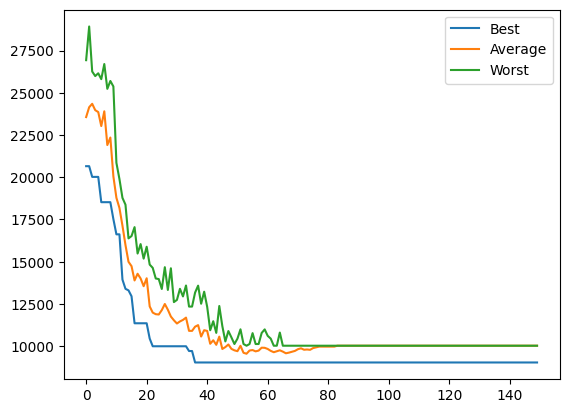

Total distance: 9036.0
Best tour: [0, 21, 31, 48, 34, 35, 38, 39, 37, 36, 47, 23, 4, 14, 5, 3, 24, 11, 27, 26, 25, 46, 12, 13, 51, 10, 50, 45, 43, 15, 28, 29, 6, 1, 41, 20, 30, 22, 49, 19, 17, 2, 16, 44, 18, 40, 7, 8, 9, 42, 32, 33]


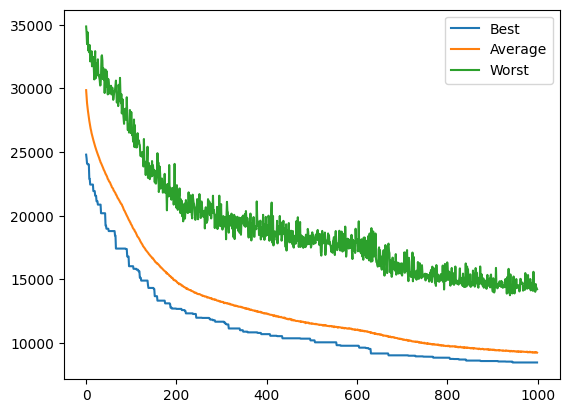

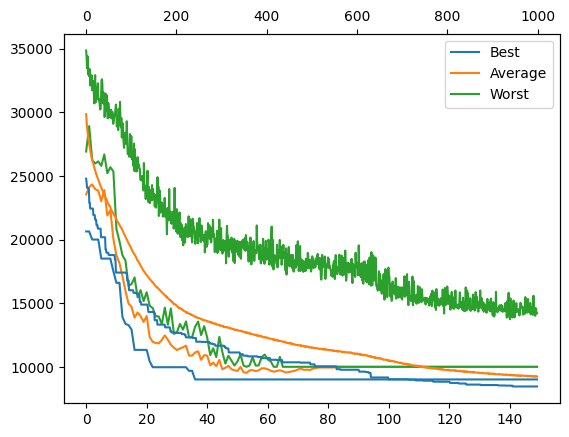

In [12]:
import numpy as np
import tsplib95
import networkx as nx
import matplotlib.pyplot as plt
from Ants import ant_iteration

def tour_length(ant, distances):
    length = distances[ant[0], ant[len(ant)-1]]
    for i in range(len(ant)):
        length += distances[ant[i-1], ant[i]]
    return length

def solve_tsp_with_ants(distances, num_ants=10, num_iterations=100, evaporation_rate=0.5):
    pheromone = np.ones(distances.shape) / len(distances) # initial pheromone level on each edge

    best_tour = None
    best_length = float('inf')
    bests = []
    avgs = []
    worsts = []

    for _ in range(num_iterations):
        ant_tours = ant_iteration(distances, pheromone, num_ants)
        
        # update the pheromone levels on each edge based on the tour lengths
        pheromone *= evaporation_rate
        for ant in range(num_ants):
            tour = ant_tours[ant]
            tour_distance = tour_length(tour, distances)
            
            # update the pheromone levels on each edge in the tour
            for i in range(len(tour)-1):
                pheromone[tour[i], tour[i+1]] += 1/tour_distance
            pheromone[tour[len(tour)-1], tour[0]] += 1/tour_distance

            # update the best tour and best length found so far
            if tour_distance < best_length:
                best_length = tour_distance
                best_tour = tour

        bests.append(best_length)
        # bests.append(min([tour_length(tour, distances) for tour in ant_tours]))
        worsts.append(max([tour_length(tour, distances) for tour in ant_tours]))
        avgs.append(sum([tour_length(tour, distances) for tour in ant_tours]) / len(ant_tours))
    
    return best_tour, best_length, (bests, avgs, worsts)


def read_tsp_file(filename):
    with open(filename) as f:
        return nx.to_numpy_array(tsplib95.read(f).get_graph())

best_tour, best_length, data1 = solve_tsp_with_ants(read_tsp_file('berlin52.tsp'), 10, 150, 0.5)
bests, avgs, worsts = data1

utils.plot_stats([i for i in range(len(bests))], *data1)

print("Total distance:", best_length)
print("Best tour:", best_tour)

_, data2 = solve_tsp(utils.read_tsp('berlin52.tsp'), False, sum_of_costs_cyclic, TSPChromosome, 2000, 1000)
bests2, avgs2, worsts2 = data2

def plot_combined(data1, data2):
    bests_ants, avgs_ants, worsts_ants = data1
    bests_normal, avgs_normal, worsts_normal = data2
    fig, ax_left = plt.subplots()
    

    ax_left.plot([i for i in range(len(bests_ants))], bests_ants, label="Best Ants")
    ax_left.plot([i for i in range(len(bests_ants))], avgs_ants, label="Average Ants")
    ax_left.plot([i for i in range(len(bests_ants))], worsts_ants, label="Worst Ants")
    
    ax_right = ax_left.twiny()
    ax_right.plot([i for i in range(len(bests_normal))], bests_normal, label="Best")
    ax_right.plot([i for i in range(len(bests_normal))], avgs_normal, label="Average")
    ax_right.plot([i for i in range(len(bests_normal))], worsts_normal, label="Worst")
    plt.legend()
    plt.show()

utils.plot_stats([i for i in range(len(bests2))], *data2)
plot_combined(data1, data2)